In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
from pylab import *
from scipy.optimize import curve_fit
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [131]:
# Energy as function of angle
dataDict = {
'State' : pd.Series(['FM','AFM','FM','AFM','FM','AFM','FM','AFM','FM','AFM','FM','AFM','FM','AFM'],index=['0','0', '15','15', '30','30','45','45','60','60','75','75','90', '90']),
'Total Energy' : pd.Series([-223.9842666, -223.9853412, -223.9849268,-223.9855121,-223.983616,-223.9858769,-223.9811426,-223.9856887,-223.977814,-223.9809027,-223.9666981,-223.9699511,-223.9487315,-223.9504364], index=['0','0', '15','15', '30','30','45','45','60','60','75','75','90', '90']),
'Energy Error' : pd.Series([0.000198749851,0.0002006422582,0.0002021910102,0.0001981985947,0.0002058370136,0.000197865291,0.0002035847029,0.0002077939487,0.0001998573641,0.0002029641835,0.0002013813606,0.0002082358912,0.0001978426595,0.0002056810956],index=['0','0', '15','15', '30','30','45','45','60','60','75','75','90', '90'])
}
keyData = pd.DataFrame(dataDict)

In [132]:
#Calculating energy differenes
angle =[0,15,30,45,60,75,90]
afm = []
fm = []
errfm=[]
errafm=[]
for index, row in keyData.iterrows():
    if row[1] == 'FM':
        fm.append(row[2])
        errfm.append(row[0])
    else:
        afm.append(row[2])
        errafm.append(row[0])
afm = np.asarray(afm)
fm = np.asarray(fm)
errfm=np.asarray(errfm)
errafm=np.asarray(errafm)
diff= afm-fm
errdiff = ((errafm)**2+(errfm)**2)**(1/2)

In [138]:
#Raw Data upload
df = pd.read_json('allobdm.json')
df=df.sort('angle')
df.index = range(0,len(df))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [139]:
#Fit function
def func(x, a, b, c):
    return a*np.exp(-b*(x))+c

In [140]:
#Filter for which matrix elements are of most interest
def sigelements(matrix,siglist,storage):
    temp =[]
    for i in range(13):
        for j in range(13):
            if i == j:
                break
            elif abs(matrix[i][j]) > 0.05:  
                temp.append((i,j)) 
    storage['sig'] = temp
    siglist.append(storage)
    return siglist

In [141]:
#Construct lists of interesting coordinates for up and down spins
sigupfm = []
sigupafm = []
for i in range(14):
    storage = {'angle':df['angle'][i], 'sig':[]}
    if df['state'][i] == 'FM':
        obdm = df['upmatrix'][i]
        sigelements(obdm,sigupfm,storage)
    else:
        obdm = df['upmatrix'][i]
        sigelements(obdm,sigupafm,storage)

sigdownfm = []
sigdownafm = []
for i in range(14):
    storage = {'angle':df['angle'][i], 'sig':[]}
    if df['state'][i] == 'FM':
        obdm = df['downmatrix'][i]
        sigelements(obdm,sigdownfm,storage)
    else:
        obdm = df['downmatrix'][i]
        sigelements(obdm,sigdownafm,storage)
sigupafm

[{'angle': 0, 'sig': [(8, 7), (9, 5), (10, 6)]},
 {'angle': 15, 'sig': [(8, 7), (9, 5), (10, 6), (11, 10)]},
 {'angle': 30, 'sig': [(7, 6), (8, 7), (9, 5), (10, 6)]},
 {'angle': 45, 'sig': [(7, 6), (8, 7), (9, 5), (10, 6)]},
 {'angle': 60, 'sig': [(8, 7), (9, 5), (10, 6)]},
 {'angle': 75, 'sig': [(8, 7), (9, 5), (10, 6)]},
 {'angle': 90, 'sig': [(6, 3), (7, 6), (8, 7), (9, 5), (10, 6)]}]

In [142]:
#Pull OBDM elements based on interesting coordinates
def obdmelements(angle,matrix,errmatrix,coordinates,out):
    storage = {'angle':angle, 'value':0,'err':0,'coord':coordinates}
    storage['value'] = matrix[coordinates[0]][coordinates[1]]
    storage['err'] = errmatrix[coordinates[0]][coordinates[1]]
    return out.append(storage)

In [143]:
#For each magnetic state and spin, compile the matrix elements associated with each coordinate
fmupcoord = [(7,6)]
fmup = [] 
for i in range(14):
    if df['state'][i] =='FM':
        for coord in fmupcoord:
            obdmelements(df['angle'][i],df['upmatrix'][i],df['uperr'][i],coord,fmup)

            
fmdowncoord = [(6,2),(7,0)]
fmdown =[]
for i in range(14):
    if df['state'][i] =='FM':
        for coord in fmdowncoord:
            obdmelements(df['angle'][i],df['downmatrix'][i],df['downerr'][i],coord,fmdown)

            
afmupcoord = [(10,6)]
afmup = []
for i in range(14):
    if df['state'][i] =='AFM':
        for coord in afmupcoord:
            obdmelements(df['angle'][i],df['upmatrix'][i],df['uperr'][i],coord,afmup)

afmdowncoord = [(6,2),(6,3),(7,0)]
afmdown = []
for i in range(14):
    if df['state'][i] =='AFM':
        for coord in afmdowncoord:
            obdmelements(df['angle'][i],df['downmatrix'][i],df['downerr'][i],coord,afmdown)

In [144]:
#Group particular matrix elements together from the grand list
afmdown.sort(key=itemgetter('coord'))
ad =[]
for key,items in itertools.groupby(afmdown,itemgetter('coord')):
    ad.append(list(items)) 

afmup.sort(key=itemgetter('coord'))
au =[]
for key,items in itertools.groupby(afmup,itemgetter('coord')):
    au.append(list(items)) 

fmup.sort(key=itemgetter('coord'))
fu =[]
for key,items in itertools.groupby(fmup,itemgetter('coord')):
    fu.append(list(items)) 

fmdown.sort(key=itemgetter('coord'))
fd =[]
for key,items in itertools.groupby(fmdown,itemgetter('coord')):
    fd.append(list(items)) 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


[ -4.15809540e+00   5.07674502e+01  -5.71603946e-04]


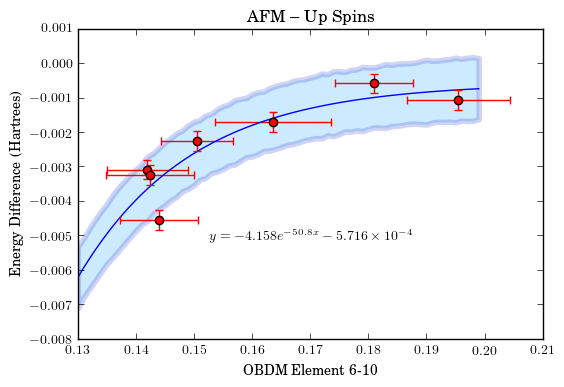

In [151]:
#Plotting

check = au[0]
obdmelem = []
obdmerr = []
for i in range(7):
    obdmelem.append(check[i]['value'])
    obdmerr.append(check[i]['err'])
obdmelem = np.asarray(obdmelem)
obdmerr = np.asarray(obdmerr)
inds = obdmelem.argsort()
sortedErr =obdmerr[inds]
sortedobdm = np.sort(obdmelem)
sortedDiff = diff[inds]
sortedDiffErr = errdiff[inds]

popt, pcov = curve_fit(func, sortedobdm, sortedDiff, [-2.15001007e-07,3.81735185e+01,-4.72230001e-04])
x=np.arange(0.13, 0.2, .001)
print(popt)
y= popt[0]*exp(-popt[1]*x)+popt[2]
error = np.random.normal(0.0009, 0.00002, size=y.shape)
plt.fill_between(x, y-error, y+error,    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, antialiased=True)
plt.plot(x, y)
plt.text(0.17, -0.005,r'$y = -4.158e^{-50.8x}-5.716\times 10^{-4}$', horizontalalignment='center',
     verticalalignment='center')

plt.errorbar(sortedobdm,sortedDiff,xerr=sortedErr,yerr=sortedDiffErr,marker='o',color='r',mew=1,linestyle='None')
plt.ylabel('Energy Difference (Hartrees)')
plt.xlabel('OBDM Element 6-10')
plt.title('AFM -- Up Spins')
plt.show()

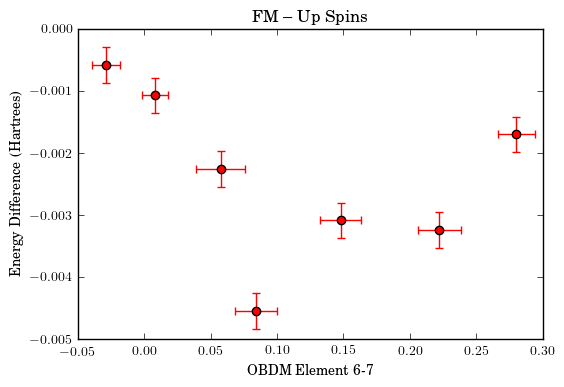

In [154]:
check = fu[0]
obdmelem = []
obdmerr = []
for i in range(7):
    obdmelem.append(check[i]['value'])
    obdmerr.append(check[i]['err'])
obdmelem = np.asarray(obdmelem)
obdmerr = np.asarray(obdmerr)
inds = obdmelem.argsort()
sortedErr =obdmerr[inds]
sortedobdm = np.sort(obdmelem)
sortedDiff = diff[inds]
sortedDiffErr = errdiff[inds]

#popt, pcov = curve_fit(func, sortedobdm, sortedDiff, [-2.15001007e-07,3.81735185e+01,-4.72230001e-04])
#x=np.arange(0.13, 0.2, .001)
#print(popt)
#y= popt[0]*exp(-popt[1]*x)+popt[2]
#error = np.random.normal(0.0009, 0.00002, size=y.shape)
#plt.fill_between(x, y-error, y+error,    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#    linewidth=4, antialiased=True)
#plt.plot(x, y)
#plt.text(0.17, -0.005,r'$y = -4.158e^{-50.8x}-5.716\times 10^{-4}$', horizontalalignment='center',
#     verticalalignment='center')

plt.errorbar(sortedobdm,sortedDiff,xerr=sortedErr,yerr=sortedDiffErr,marker='o',color='r',mew=1,linestyle='None')
plt.ylabel('Energy Difference (Hartrees)')
plt.xlabel('OBDM Element 6-7')
plt.title('FM -- Up Spins')
plt.show()

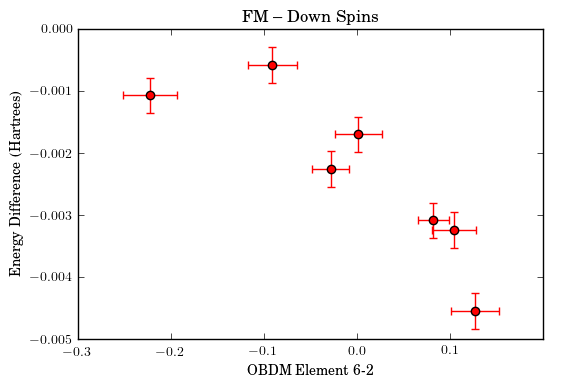

In [160]:
check = fd[0]
obdmelem = []
obdmerr = []
for i in range(7):
    obdmelem.append(check[i]['value'])
    obdmerr.append(check[i]['err'])
obdmelem = np.asarray(obdmelem)
obdmerr = np.asarray(obdmerr)
inds = obdmelem.argsort()
sortedErr =obdmerr[inds]
sortedobdm = np.sort(obdmelem)
sortedDiff = diff[inds]
sortedDiffErr = errdiff[inds]

#popt, pcov = curve_fit(func, sortedobdm, sortedDiff, [-2.15001007e-07,3.81735185e+01,-4.72230001e-04])
#x=np.arange(0.13, 0.2, .001)
#print(popt)
#y= popt[0]*exp(-popt[1]*x)+popt[2]
#error = np.random.normal(0.0009, 0.00002, size=y.shape)
#plt.fill_between(x, y-error, y+error,    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#    linewidth=4, antialiased=True)
#plt.plot(x, y)
#plt.text(0.17, -0.005,r'$y = -4.158e^{-50.8x}-5.716\times 10^{-4}$', horizontalalignment='center',
#     verticalalignment='center')

plt.errorbar(sortedobdm,sortedDiff,xerr=sortedErr,yerr=sortedDiffErr,marker='o',color='r',mew=1,linestyle='None')
plt.ylabel('Energy Difference (Hartrees)')
plt.xlabel('OBDM Element 6-2')
plt.title('FM -- Down Spins')
plt.show()

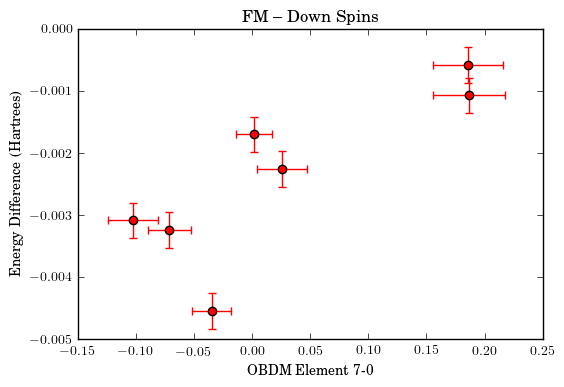

In [156]:
check = fd[1]
obdmelem = []
obdmerr = []
for i in range(7):
    obdmelem.append(check[i]['value'])
    obdmerr.append(check[i]['err'])
obdmelem = np.asarray(obdmelem)
obdmerr = np.asarray(obdmerr)
inds = obdmelem.argsort()
sortedErr =obdmerr[inds]
sortedobdm = np.sort(obdmelem)
sortedDiff = diff[inds]
sortedDiffErr = errdiff[inds]

#popt, pcov = curve_fit(func, sortedobdm, sortedDiff, [-2.15001007e-07,3.81735185e+01,-4.72230001e-04])
#x=np.arange(0.13, 0.2, .001)
#print(popt)
#y= popt[0]*exp(-popt[1]*x)+popt[2]
#error = np.random.normal(0.0009, 0.00002, size=y.shape)
#plt.fill_between(x, y-error, y+error,    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#    linewidth=4, antialiased=True)
#plt.plot(x, y)
#plt.text(0.17, -0.005,r'$y = -4.158e^{-50.8x}-5.716\times 10^{-4}$', horizontalalignment='center',
#     verticalalignment='center')

plt.errorbar(sortedobdm,sortedDiff,xerr=sortedErr,yerr=sortedDiffErr,marker='o',color='r',mew=1,linestyle='None')
plt.ylabel('Energy Difference (Hartrees)')
plt.xlabel('OBDM Element 7-0')
plt.title('FM -- Down Spins')
plt.show()

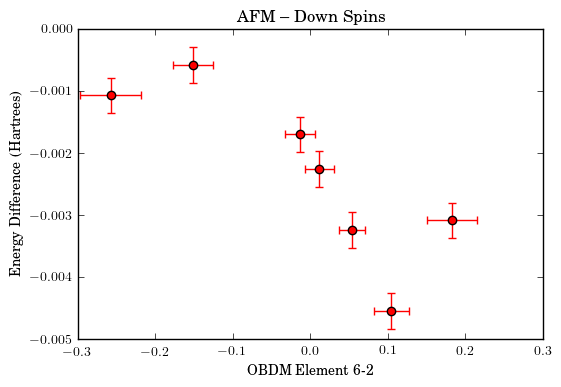

In [157]:
check = ad[0]
obdmelem = []
obdmerr = []
for i in range(7):
    obdmelem.append(check[i]['value'])
    obdmerr.append(check[i]['err'])
obdmelem = np.asarray(obdmelem)
obdmerr = np.asarray(obdmerr)
inds = obdmelem.argsort()
sortedErr =obdmerr[inds]
sortedobdm = np.sort(obdmelem)
sortedDiff = diff[inds]
sortedDiffErr = errdiff[inds]

#popt, pcov = curve_fit(func, sortedobdm, sortedDiff, [-2.15001007e-07,3.81735185e+01,-4.72230001e-04])
#x=np.arange(0.13, 0.2, .001)
#print(popt)
#y= popt[0]*exp(-popt[1]*x)+popt[2]
#error = np.random.normal(0.0009, 0.00002, size=y.shape)
#plt.fill_between(x, y-error, y+error,    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#    linewidth=4, antialiased=True)
#plt.plot(x, y)
#plt.text(0.17, -0.005,r'$y = -4.158e^{-50.8x}-5.716\times 10^{-4}$', horizontalalignment='center',
#     verticalalignment='center')

plt.errorbar(sortedobdm,sortedDiff,xerr=sortedErr,yerr=sortedDiffErr,marker='o',color='r',mew=1,linestyle='None')
plt.ylabel('Energy Difference (Hartrees)')
plt.xlabel('OBDM Element 6-2')
plt.title('AFM -- Down Spins')
plt.show()

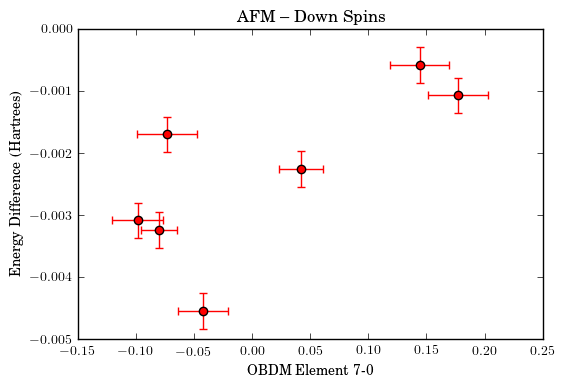

In [159]:
check = ad[2]
obdmelem = []
obdmerr = []
for i in range(7):
    obdmelem.append(check[i]['value'])
    obdmerr.append(check[i]['err'])
obdmelem = np.asarray(obdmelem)
obdmerr = np.asarray(obdmerr)
inds = obdmelem.argsort()
sortedErr =obdmerr[inds]
sortedobdm = np.sort(obdmelem)
sortedDiff = diff[inds]
sortedDiffErr = errdiff[inds]

#popt, pcov = curve_fit(func, sortedobdm, sortedDiff, [-2.15001007e-07,3.81735185e+01,-4.72230001e-04])
#x=np.arange(0.13, 0.2, .001)
#print(popt)
#y= popt[0]*exp(-popt[1]*x)+popt[2]
#error = np.random.normal(0.0009, 0.00002, size=y.shape)
#plt.fill_between(x, y-error, y+error,    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#    linewidth=4, antialiased=True)
#plt.plot(x, y)
#plt.text(0.17, -0.005,r'$y = -4.158e^{-50.8x}-5.716\times 10^{-4}$', horizontalalignment='center',
#     verticalalignment='center')

plt.errorbar(sortedobdm,sortedDiff,xerr=sortedErr,yerr=sortedDiffErr,marker='o',color='r',mew=1,linestyle='None')
plt.ylabel('Energy Difference (Hartrees)')
plt.xlabel('OBDM Element 7-0')
plt.title('AFM -- Down Spins')
plt.show()